In [59]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

In [60]:
file_path = '_raw_yt_metadata.jsonl'
chunk_size = 100000

chunks = []

for chunk in pd.read_json(file_path, lines=True, chunksize=chunk_size):
    chunks.append(chunk)
    break

df = pd.concat(chunks, ignore_index=True)

Before everything, let's remove videos with empty categories to preprocess our data 

In [62]:
count_empty_categories = (df["categories"]=="").sum()
print(f"Number of empty lines : {count_empty_categories}")

df = df[df["categories"] != ""]

Number of empty lines : 1


# Comments about the data and the project

In [66]:
df.head(2)

,categories,channel_id,crawl_date,description,dislike_count,display_id,duration,like_count,tags,title,upload_date,view_count
0,Entertainment,UCzzzrOhp92PkGrIwGH3_EEg,2019-11-22 18:08:02.988358,Мой ВК: https://vk.com/holdik_clash\nМой инста...,48.0,e3qGZIDcMK4,495,5138.0,"холдик,холдик бомбит,холдик нарезка,нарезка со...","ЛИЦО, КАК ЛИЦО - ВЫБИЛ ФРЭНКА! НАРЕЗКА СО СТРИ...",2019-09-24 00:00:00,52193
1,Entertainment,UCzzzrOhp92PkGrIwGH3_EEg,2019-11-22 18:08:03.607261,Мой ВК: https://vk.com/holdik_clash\nМой инста...,60.0,11em10cFRbo,666,4893.0,"холдик,холдик бомбит,холдик нарезка,нарезка со...",АВТОАТАКА МОЯ ЖИЗНЬ! Я ДОНАТЕР - МНЕ ПРОСТИТЕЛ...,2019-09-21 00:00:00,46523



-> Video data : 'from 2005-05-24 to 2019-11-20.'

-> Times series data : 'from early January 2015 to the end of September 2019'

-> Channels data : 'We obtained all channels with >10k subscribers and >10 videos from channelcrawler.com in the 27 October 2019.'

Idea : select the features that we are interested in, and create a new data file, that is less heavy (for instance : delete the video description)

goal : 
- Explore how content variety affects channel success, channels with varied content should attract more people, while channels that stick to one category might show more viewers loyalty

1) link between diversity and number of subscribers
2) link between diversity and number of view

**We need to define diversity first.**

- Creation of a youtube categories spacial representation. Is there categories that are often link together.

**We need to define the distance between categories.**

**We must write low time complexity function because the dataset is very large !**

In [68]:

def get_unique_values(data, feature):
    return data[feature].unique().tolist()

get_unique_values(df, 'channel_id')
    

['UCzzzrOhp92PkGrIwGH3_EEg',
 'UCzzzZ3-icktxbC3j7hkWqRw',
 'UCzzzUN8yvD2LRAnY-lhzyLQ',
 'UCzzzPMh9fZHxc7gxPRB2LHQ',
 'UCzzzP7KSHDtw9XaT-PcGyJA',
 'UCzzyt9Z70MBX9RQAFVSNlpQ',
 'UCzzuPi9S7NNCdkiHAcx92Qg',
 'UCzztaOtjmaZoiLvWLagq7bg',
 'UCzzt1esHXqs__Hrp1KugqPg',
 'UCzzt-UNlRHbEFY3rEpFpuXw',
 'UCzzsKg4jPGBL05t2w3HfHBA',
 'UCzzqd0yx7h1PuC3KJVqeJgw',
 'UCzzoJY_ln_StRVdrRX1_ftg',
 'UCzzmGsmy8cBxmqljbVG_e7Q',
 'UCzzgEOi0xR9SuflkXmTQv6g',
 'UCzzfu83LhPMMuhtDVA75rfw',
 'UCzzeO6b8v8bBt7gjSWBKzOg',
 'UCzzbaQY1nPim5yroAjtXRTw',
 'UCzzamhkOmpSnZ7BSBikvKnA',
 'UCzzYnZ8GIzfB1Vr3hk2Nj9Q',
 'UCzzY0ro-Kr3S1C0vhjhkZ4w',
 'UCzzXsnHsEmGorQ6xAKL2sZA',
 'UCzzXikQ7B6ZCcmOYceFdumg',
 'UCzzX6cJ8E4C9L87PSHOweGA',
 'UCzzVUde44MyJgFhwRc1iiFA',
 'UCzzUx3uOjiRM-FsBH027O9w',
 'UCzzTgcVSmq5qyZ1-ZGEMFLA',
 'UCzzT17GEeEPojZe7FT7skag',
 'UCzzSyCWsJpSNyhspb085tag',
 'UCzzSPRyMYUw6IGueHr1K0Jg',
 'UCzzQnR2e5VIgziK3SiJ6uIg',
 'UCzzOKT1SkE7qdycJvPCR3Gg',
 'UCzzN0bL-q5EfdolAwiiBDhA',
 'UCzzMiZKrj0jBKEQj7L0rYfg',
 'UCzzLIhDbFYU

# Youtube Channel Diversity

To study the impact for diversity on performances we need to find a measurement of diversity.

**First idea** : we can do a simple count for the number different categories among the videos of the channel.

**Second idea** : we can do a simple count but with a treshold, only count the categories that reprensent a certain percentage of the total videos of the channel.

**Third idea** : create a weighted count. the idea behind it is that the more a channel have different video categories and the more those categories a evenly distributed the higher the score will be. (we case use entropie formula).


In [74]:

# Time complexity : O(number of rows) 
def get_video_category_distribution_dict(data, category_list):
    """
    Function that returns the dictionnary that associate each channel_id with
    the dictionnary that count the number of videos in each category

    {'channel_id1' : {'cat1': n1, ..., 'catK' : nK}, 'channel_id2' : ... }

    Parameters:
    data : the dataset of videos.
    category_list : the list of categories, can be easily computer with another dataset.

    Returns:
    dict: the built dictionnary.
    """

    # Dict Init
    channel_id_list = get_unique_values(data, 'channel_id')
    dict = {channel_id : {category : 0 for category in category_list} for channel_id in channel_id_list}

    for i in range(len(data)):
        channel_id = data.iloc[i]['channel_id']
        category = data.iloc[i]['categories']
        dict[channel_id][category] += 1

    return dict


In [75]:

'''it might be usefull to use a global variable for category_list, because
with the reel dataset it can be costly to get it with get_unique_values'''

categories_list = get_unique_values(df, 'categories')
dict = get_video_category_distribution_dict(df, categories_list)


In [76]:
dict['UCzzfu83LhPMMuhtDVA75rfw']

{'Entertainment': 12,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 10,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 1,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 8,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

 **Let's see if YouTubers are already covering multiple categories in their content.**

263


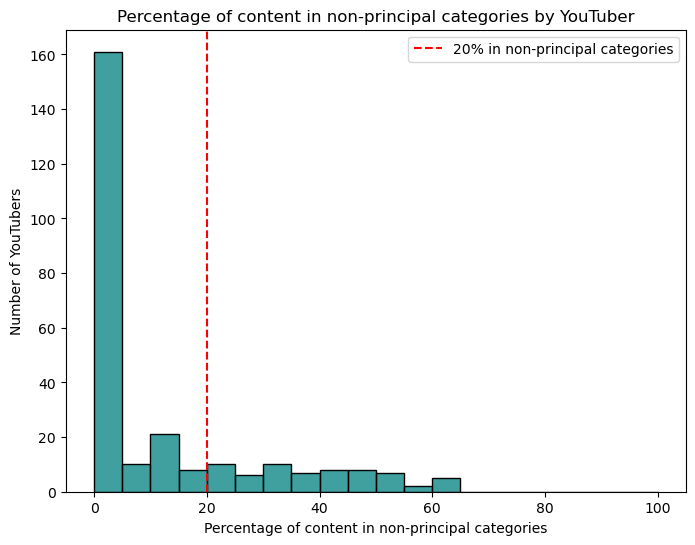

Number of YouTubers with at least 20% of content in non-principal categories: 63


In [78]:
def youtube_statistics_by_categories(youtube_dict):
    print(len(youtube_dict))
    youtubers_non_principal_category_percentages = []
    youtubers_above_20_percent = 0  
    
    for categories in youtube_dict.values():
        total_videos = sum(categories.values())
        if total_videos > 0:
            first_category_videos = max(categories.values())
            non_principal_category_videos = total_videos - first_category_videos
            percentage_in_non_principal_categories = (non_principal_category_videos / total_videos) * 100
            youtubers_non_principal_category_percentages.append(percentage_in_non_principal_categories)
            
            if percentage_in_non_principal_categories >= 20:
                youtubers_above_20_percent += 1
    
    # Affichage du graphe
    plt.figure(figsize=(8, 6))
    sns.histplot(youtubers_non_principal_category_percentages, kde=False, bins=range(0, 101, 5), color='teal')
    plt.axvline(20, color='red', linestyle='--', label='20% in non-principal categories')
    plt.title('Percentage of content in non-principal categories by YouTuber')
    plt.xlabel('Percentage of content in non-principal categories')
    plt.ylabel('Number of YouTubers')
    plt.legend()
    plt.show()

    print(f"Number of YouTubers with at least 20% of content in non-principal categories: {youtubers_above_20_percent}")

# Utilisation de la fonction
youtube_statistics_by_categories(dict)


The majority of YouTubers do not diversify their channels, with only 24% of YouTubers having at least 20% of videos in categories different from their main one.

**Let's define a metric of diversity score**

In [81]:
def get_basic_diversity_score(video_category_distribution_dict, channel_id):
    score = 0

    for value in video_category_distribution_dict[channel_id].values():
        if value > 0:
            score += 1

    return score

In [82]:
def get_threshold_diversity_score(video_category_distribution_dict, channel_id, treshold):

    video_cat_dist = video_category_distribution_dict[channel_id]
    total_video_number = sum([value for value in video_cat_dist.values()])

    score = 0

    for value in video_cat_dist.values():
        if (value > int(total_video_number * treshold)):
            score += 1

    return score

**Weighted Score : Normalized Entropy**

$C$ is the number of caterories
, $p_i$ the proportion of videos that are in the category $i$.


$$Score(p_1, ...,p_C) = - \frac{\sum _{i}^{C} p_i log (p_i)}{log(C)}$$

In [84]:
def get_weighted_diversity_score(video_category_distribution_dict, channel_id):

    video_cat_dist = video_category_distribution_dict[channel_id]
    total_video_number = sum([value for value in video_cat_dist.values()])

    C = len(video_cat_dist)
    score = 0

    for value in video_cat_dist.values():
        p = value/total_video_number
        if p != 0:
            score = score + (p * np.log(p)) # to avoid log(0)
        
    return - score / np.log(C)

In [85]:
print('Diversity score using entropy formula :',get_weighted_diversity_score(dict, channel_id = 'UCzzzrOhp92PkGrIwGH3_EEg').round(3))

Diversity score using entropy formula : 0.172


C:\Users\antoi\AppData\Local\Temp\ipykernel_25064\2101295180.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Category', x='Video Count', data=df, palette='viridis')


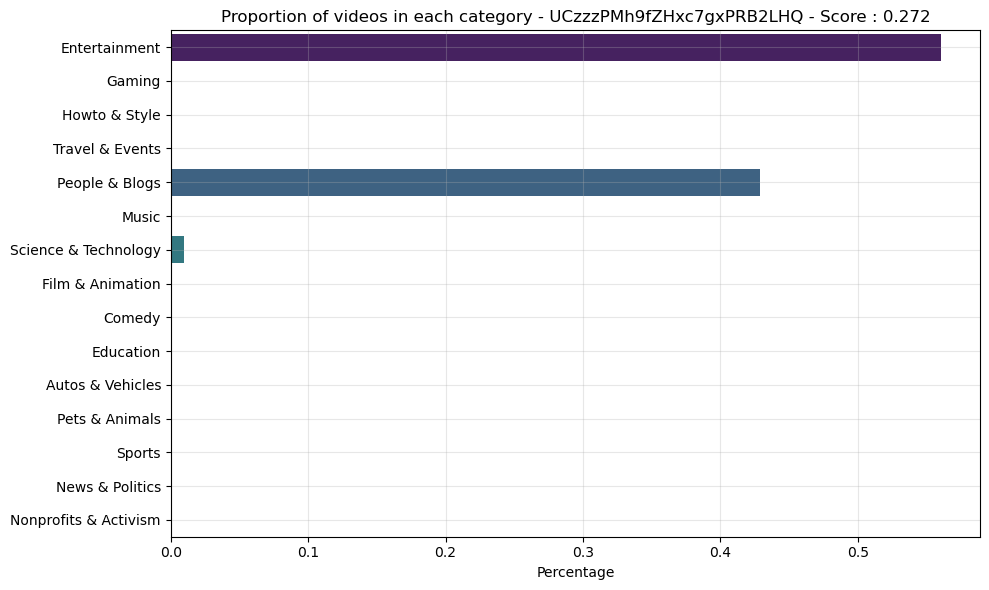

In [86]:
def plot_channel_videos_distribution(video_category_distribution_dict, channel_id):

    # Convert the value into proportions
    data = video_category_distribution_dict[channel_id].copy()
    total_video_number = sum([value for value in data.values()])
    for cat in data.keys():
        data[cat] = data[cat] / total_video_number
        
    df = pd.DataFrame(list(data.items()), columns=['Category', 'Video Count'])
    score = get_weighted_diversity_score(video_category_distribution_dict, channel_id)

    plt.figure(figsize=(10, 6))
    sns.barplot(y='Category', x='Video Count', data=df, palette='viridis')
    
    plt.xticks(rotation=90)
    plt.title(f'Proportion of videos in each category - {channel_id} - Score : {score.round(3)}')
    plt.xlabel('Percentage')
    plt.xticks(rotation=0)
    plt.ylabel('')
    plt.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

plot_channel_videos_distribution(dict, 'UCzzzPMh9fZHxc7gxPRB2LHQ')

C:\Users\antoi\AppData\Local\Temp\ipykernel_25064\2101295180.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='Category', x='Video Count', data=df, palette='viridis')


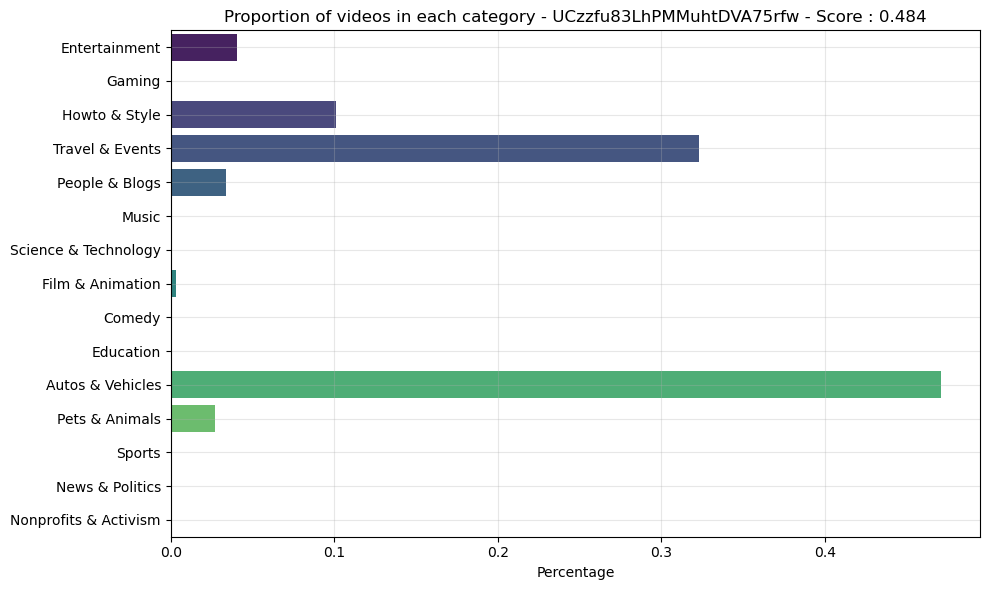

In [87]:
plot_channel_videos_distribution(dict, 'UCzzfu83LhPMMuhtDVA75rfw')

# Distances between youtube channels categories

we can define a **link strength** between categories. 

**First idea** : we can define the link strength between cat1 and cat2 by the number of time a channel has already create one video of each category

to compute this link strength, we can create a dictionnary, dict['Gaming']['Entertainment'] = link strength between 'Gaming' and 'Entertainment'


In [92]:
def get_link_strength_dict(data, video_category_distribution_dict, categories_list):

    link_strength_dict = {category : {category : 0 for category in categories_list} for category in categories_list}

    channels_id_list = get_unique_values(data, 'channel_id')

    for cat_dist in video_category_distribution_dict.values():
        for cat1 in categories_list:
            for cat2 in categories_list:
                if cat_dist[cat1] and cat_dist[cat2]:
                    link_strength_dict[cat1][cat2] += 1

    return link_strength_dict

In [93]:
def display_link_strength(data, video_category_distribution_dict, category_list):

    link_strength_dict = get_link_strength_dict(data, video_category_distribution_dict, category_list)
    df = pd.DataFrame(link_strength_dict).astype(int)

    return df

In [94]:
display_link_strength(df, dict, categories_list)

,Entertainment,Gaming,Howto & Style,Travel & Events,People & Blogs,Music,Science & Technology,Film & Animation,Comedy,Education,Autos & Vehicles,Pets & Animals,Sports,News & Politics,Nonprofits & Activism
Entertainment,99,28,26,21,57,35,18,33,23,30,13,11,17,17,6
Gaming,28,66,12,10,25,9,11,16,12,15,10,4,9,9,2
Howto & Style,26,12,58,15,37,11,20,23,12,18,12,10,9,6,1
Travel & Events,21,10,15,30,24,6,10,14,12,16,10,9,13,9,3
People & Blogs,57,25,37,24,117,31,24,40,23,30,20,15,19,17,7
Music,35,9,11,6,31,90,8,13,7,13,5,5,10,10,3
Science & Technology,18,11,20,10,24,8,37,16,9,19,12,7,11,7,2
Film & Animation,33,16,23,14,40,13,16,58,16,19,12,9,11,10,5
Comedy,23,12,12,12,23,7,9,16,34,12,7,6,10,8,4
Education,30,15,18,16,30,13,19,19,12,53,12,10,15,15,8


**Two ideas to compute the distance between categories**

$A_i$ and $B_i$ are the frequencies of categories $A$ and $B$ in channel $i$

$$\text{Cosine Similarity}(A, B) = \frac{\sum_{i=1}^{C} A_i \cdot B_i}{\sqrt{\sum_{i=1}^{C} A_i^2} \cdot \sqrt{\sum_{i=1}^{C} B_i^2}}$$

$S_A$ is the set of channels where category $A$ appears,
$S_B$ is the set of channels where category $B$ appears,

$|S_A \cap S_B|$  is the size of the intersection of the sets $S_A$ and $S_B$,

$|S_A \cup S_B|$  is the size of the union of the sets $S_A$ and $S_B$,

$$\text{Jaccard Similarity}(A, B) = \frac{|S_A \cap S_B|}{|S_A \cup S_B|}$$

In [96]:
def jaccard_similarity(cat1, cat2, video_category_distribution_dict):

    intersection = 0
    union = 0

    for dict in video_category_distribution_dict.values():
        if dict[cat1] and dict[cat2]:
            intersection+=1
        if dict[cat1] or dict[cat2]:
            union+=1

    return intersection/union
    

In [97]:
def cosine_similarity(cat1, cat2, video_category_distribution_dict):

    result, n1, n2 = 0, 0, 0

    for dict in video_category_distribution_dict.values():
        result += dict[cat1]*dict[cat2]
        n1 += dict[cat1]**2
        n2 += dict[cat2]**2

    return result / (np.sqrt(n1) * np.sqrt(n2))

In [98]:
def compute_distance(cat1, cat2, video_category_distribution_dict):

    for dict in video_category_distribution_dict.values():
        if dict[cat2] == 0:
            return 0
        else:
            return 1-1/dict[cat2]
    

In [99]:
cosine_similarity('Music', 'Entertainment', dict)

0.004942308220501331

In [100]:
jaccard_similarity('Music', 'Entertainment', dict)

0.22727272727272727

In [102]:
def display_similarity(data, video_category_distribution_dict, categories_list, similarity_function):
    similarity_dict = {cat : {cat : 0 for cat in categories_list} for cat in categories_list}
    for cat1 in categories_list:
        for cat2 in categories_list:
            similarity_dict[cat1][cat2] = similarity_function(cat1, cat2, video_category_distribution_dict)
        
    df = pd.DataFrame(similarity_dict)

    return df



In [103]:
def plot_heatmap(df):
    # Créer la heatmap avec Seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(df, annot=True, cmap='Blues', fmt=".2f", linewidths=0.5, cbar_kws={'label': 'Similarity'})
    plt.title('Category Similarity Heatmap')
    plt.show()

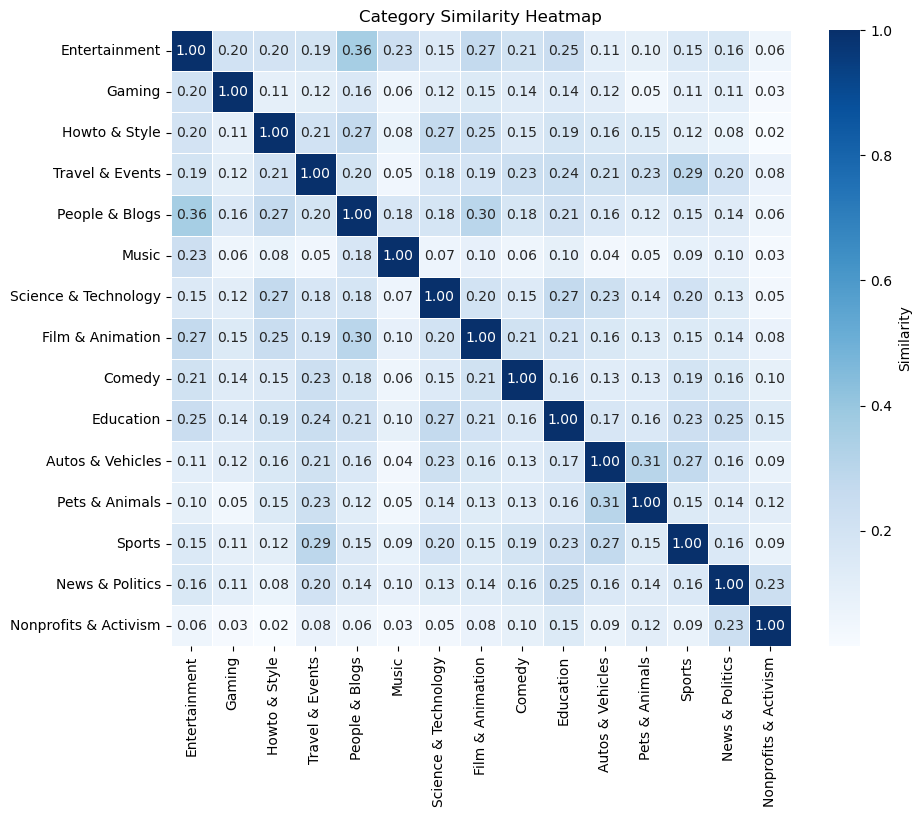

In [104]:
plot_heatmap(display_similarity(df, dict, categories_list, jaccard_similarity))

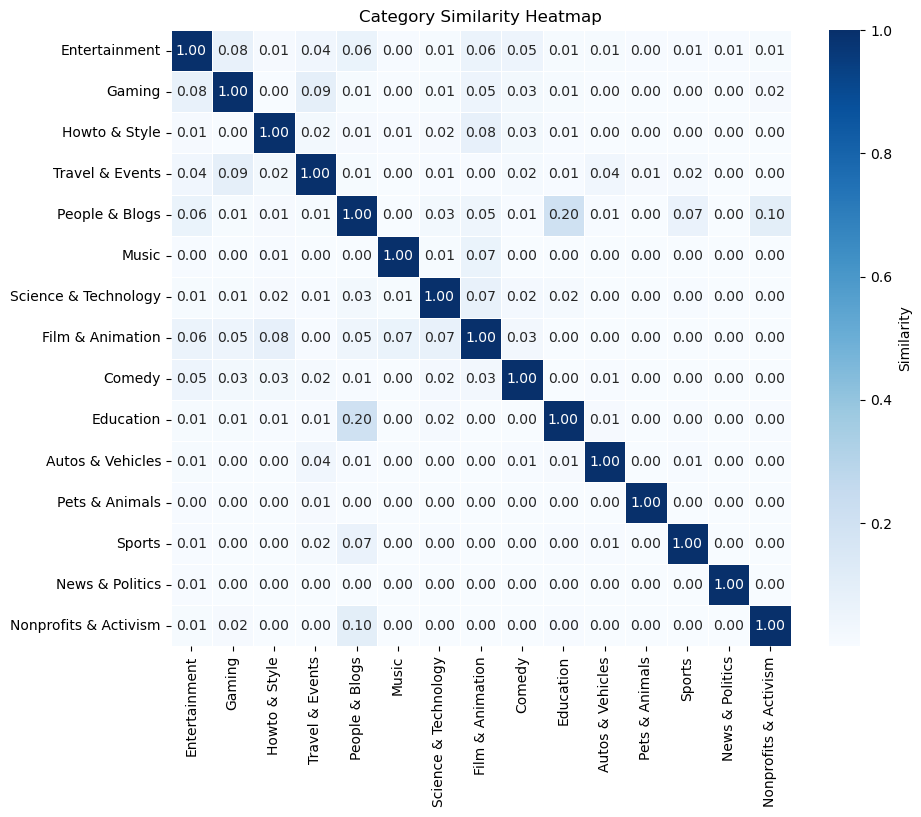

In [105]:
plot_heatmap(display_similarity(df, dict, categories_list, cosine_similarity))

**Problem**: We want to identify YouTube video categories that often appear together on creators' channels. However, the metrics we’re currently using face challenges in accurately capturing this, partly due to noise from small numbers of videos and differences in how categories are distributed. Here are two specific limitations:

Jaccard Similarity: This metric doesn’t effectively distinguish between channels that focus mainly on one category versus those with a more balanced mix. For example, a channel with 49 "gaming" videos and just 1 "sports" video would have the same Jaccard similarity between "gaming" and "sports" as a channel with 25 "gaming" and 25 "sports" videos, since Jaccard only considers whether each category is present or not. This makes it hard to capture the real connection between categories.

Cosine Similarity: This metric is also insensitive to differences in video counts between categories. For example, a channel with 50 "gaming" and 50 "music" videos could show the same cosine similarity between "gaming" and "music" as a channel with just 1 video in each category. This focus on relative proportions, instead of the actual counts, makes it harder to measure how strongly categories are paired.

**Solutions**:


To fix Jaccard Similarity problem, we can define :
Weighted Jaccard Similarity as following 
$$
\text{Weighted Jaccard Similarity}(A, B) = \frac{\sum_i \min(A_i, B_i)}{\sum_i \max(A_i, B_i)}
$$

where $A_i$ and $B_i$ represents the numbers of occurences of category $A$ and $B$ for the channel $i$.


In [109]:
def weighted_jaccard_similarity(cat1, cat2, video_category_distribution_dict):

    intersection_sum = 0
    union_sum = 0
    
    for counts in video_category_distribution_dict.values():
        count_cat1 = counts.get(cat1, 0)
        count_cat2 = counts.get(cat2, 0)

        intersection_sum += min(count_cat1, count_cat2)
        union_sum += max(count_cat1, count_cat2)
    
    if union_sum == 0:
        return 0
    
    return intersection_sum / union_sum


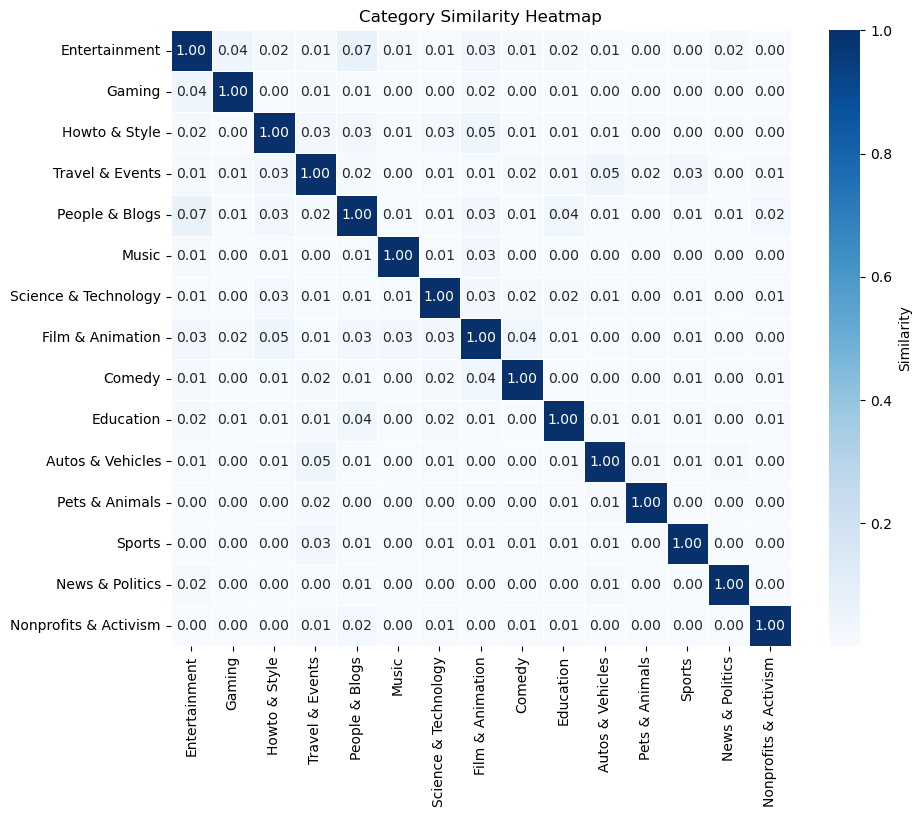

In [110]:
plot_heatmap(display_similarity(df, dict, categories_list, weighted_jaccard_similarity))

To fix the issue of noise caused by categories with few occurrences, we can filter out these categories by setting a threshold based on the percentage of a category's presence in a channel before it is considered.

In [112]:
def filter_categories_by_threshold(dico, threshold=0.1):

    for channel, category_data in dico.items():
        total_videos = sum(category_data.values())  
        if total_videos == 0:
            continue  
        

        for category, count in category_data.items():
            proportion = count / total_videos 
            if proportion < threshold:
                category_data[category] = 0  
                
    return dico


In [113]:
dict['UCzzfu83LhPMMuhtDVA75rfw']


{'Entertainment': 12,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 10,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 1,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 8,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

In [114]:
filter_categories_by_threshold(dict)['UCzzfu83LhPMMuhtDVA75rfw']

{'Entertainment': 0,
 'Gaming': 0,
 'Howto & Style': 30,
 'Travel & Events': 96,
 'People & Blogs': 0,
 'Music': 0,
 'Science & Technology': 0,
 'Film & Animation': 0,
 'Comedy': 0,
 'Education': 0,
 'Autos & Vehicles': 140,
 'Pets & Animals': 0,
 'Sports': 0,
 'News & Politics': 0,
 'Nonprofits & Activism': 0}

In [115]:
dict2 = filter_categories_by_threshold(dict)

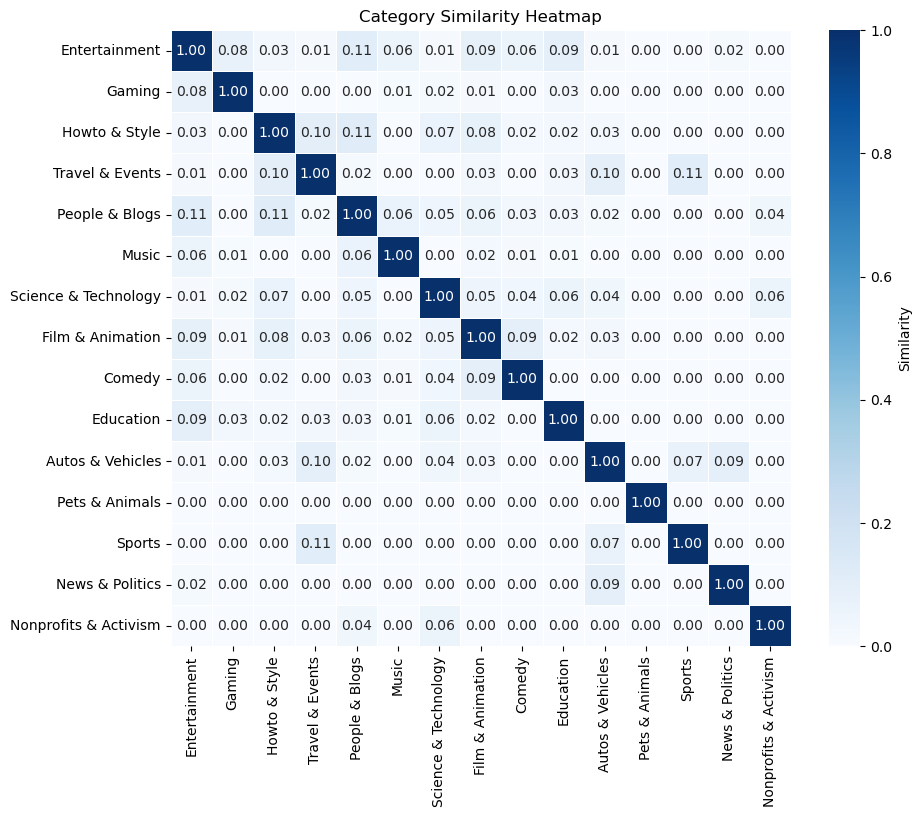

In [116]:
plot_heatmap(display_similarity(df, dict2, categories_list, jaccard_similarity))

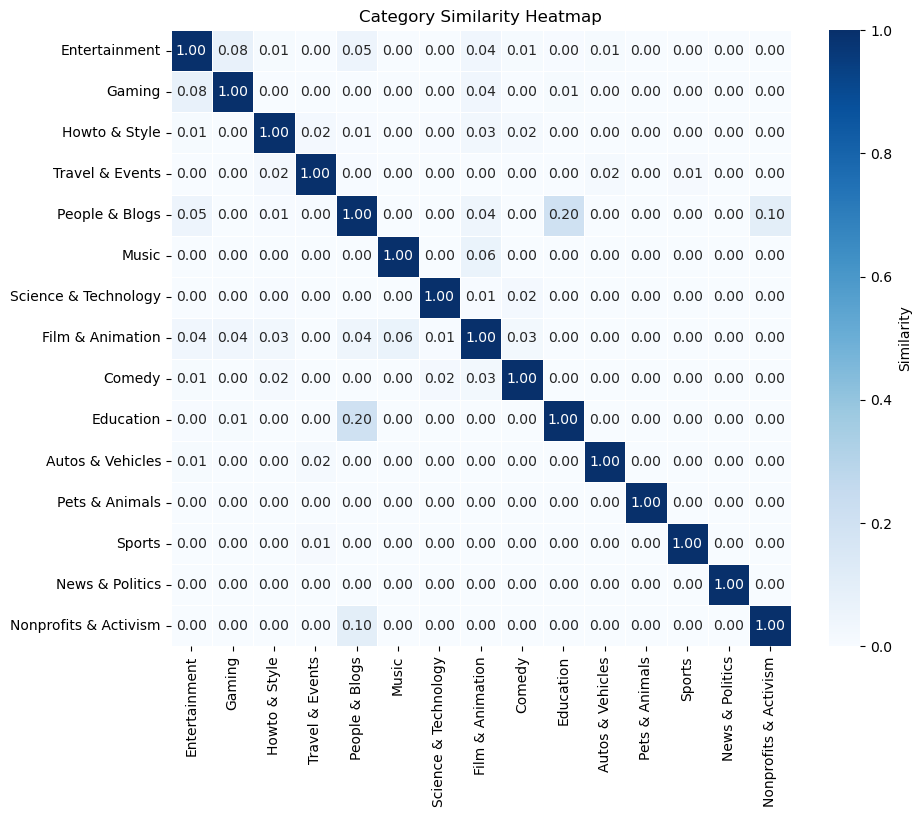

In [117]:
plot_heatmap(display_similarity(df, dict2, categories_list, cosine_similarity))

## Correlation avec le nombre d'abonnés, vues & graphe sur la diversité 
## Fonction inverse (attention proche de 0 donc renormaliser)

In [ ]:
def compute_distance(cat1, cat2, video_category_distribution_dict):

    for dict in video_category_distribution_dict.values():
        if dict[cat2] == 0:
            return 0
        else:
            return 1-1/dict[cat2]
    